In [1]:
# coding=utf-8
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
import copy
sys.path.append('/disk1//home/wangrj/higherorder/signal')
sys.path.append('/disk1/home/wangrj/LDC/MLDC-master/software/LDCpipeline/scripts')
from pycbc import types,fft
from pycbc.filter import highpass,lowpass_fir, matched_filter, matched_filter_core,sigmasq
from pycbc.psd import welch, interpolate
from pycbc.psd.read import from_numpy_arrays
from pycbc.conversions import q_from_mass1_mass2,mchirp_from_mass1_mass2,primary_mass,secondary_mass
from pycbc.conversions import mass1_from_mchirp_q,mass2_from_mchirp_q
from gensignal import gen_signal,gen_signal_fre,get_fd_htilde_lm,get_fd_LISATDI,func_wfTDI, get_TDI
from pycbc.waveform.utils import phase_from_frequencyseries,amplitude_from_frequencyseries
from pycbc.waveform import get_td_waveform,get_fd_waveform

import Cosmology
import LISAConstants as LC
from LISAhdf5 import LISAhdf5,ParsUnits
from pyFDresponse import *
from tdi import noisepsd_T,noisepsd_AE
from psd import parse_arguments,Series
from GenerateFD_SignalTDIs import ComputeTD
from LISACommonFunctions import FourierTransformData
import lal


In [2]:
# Planck 2015 data, let's udopt it here.
Omegam = 0.3175
Omegalam = 0.6825
H0 = 67.1

Tobs=3600*24*100
del_t=5

[0.00000e+00 1.00000e-06 2.00000e-06 ... 9.99998e-01 9.99999e-01
 1.00000e+00]


<function matplotlib.pyplot.show(*args, **kw)>

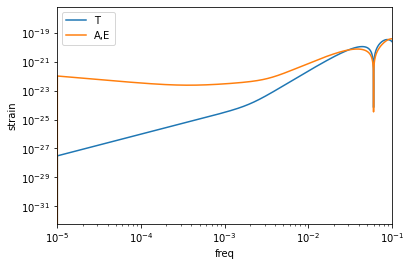

In [3]:
%matplotlib inline
#analytic PSD of noise for TDI A, E and T
del_f= 1e-6
f= np.arange(1e-5,1.0,del_f)
flen = int(1.0/del_f)+1
flow=1e-5
#freq= logsampling(1e-5,1.0,200)
PSD_TDIT= noisepsd_T(f)
PSD_TDIAE= noisepsd_AE(f)
PSD_TDIT = from_numpy_arrays(f, PSD_TDIT, flen, del_f,flow)
PSD_TDIAE = from_numpy_arrays(f, PSD_TDIAE, flen, del_f,flow)
print(PSD_TDIAE.sample_frequencies)
# plt.loglog(f,np.sqrt(PSD_TDIT*f),label='T')
# plt.loglog(f,np.sqrt(PSD_TDIAE*f),label='A,E')
plt.loglog(PSD_TDIT.sample_frequencies,np.sqrt(PSD_TDIT*PSD_TDIT.sample_frequencies),label='T')
plt.loglog(PSD_TDIAE.sample_frequencies,np.sqrt(PSD_TDIAE*PSD_TDIAE.sample_frequencies),label='A,E')
plt.xlabel('freq')
plt.ylabel('strain')
plt.xlim(1e-5,1e-1)
plt.legend()
plt.show

In [5]:
#generate the template waveform
##MBHBs parameters
z=1
m1s=2e5
m2s=2e4

#dimensionless spins: a=cos(theta_s)*s
chi1 = 0.0
chi2 = 0.0


#t0= np.random.uniform(0.0,5.0)
t0=0.05
#Ecliptic Longitude, Latitude
theta=1.0
phi=1.5
lambd =  phi 
beta = np.pi/2 -theta

inc = 0.5
DL = Cosmology.DL(z, w=0)[0] # in Mpc
print('Dl',DL)

#phi0 = np.random.uniform(0.0, 2.0*np.pi)
#psi = np.random.uniform(0.0, 2.0*np.pi)   #pols=psi
psi=0.8
phi0=0.0
print('t0,phi0,psi',t0,phi0,psi)
# So far, the only choice implemented: MLDC trajectories and TDI XYZ
[fRef, trajdict, TDItag] = [0., trajdict_MLDC, "TDIAET"]


#Masses quoted in the hdf5 files are always redshifted masses.
# m1 =  m1s*(1+z)  ### redshifted masses
# m2 =  m2s*(1+z)
m1=m1s
m2=m2s
print('m1,m2',m1,m2)
chirp_mass=mchirp_from_mass1_mass2(m1,m2)
q=q_from_mass1_mass2(m1,m2)
print(chirp_mass,q)
print(mass1_from_mchirp_q(chirp_mass,q),mass2_from_mchirp_q(chirp_mass,q))



Dl 6823.090480179816
t0,phi0,psi 0.05 0.0 0.8
m1,m2 200000.0 20000.0
49289.164742357876 10.0
200000.00000000006 20000.000000000007


In [6]:
apx=['SEOBNRv4HM','IMRPhenomXHM']
modes=[[[2,2]],[[2,2],[2,1],[3,2],[3,3],[4,4]]] 
#htilde
hlm={}
minindex=0
for i in range(len(modes[1])):
    l,m= modes[1][i]
    hlm[l,m]= get_fd_htilde_lm(chirp_mass,q,DL,inc,phi0,chi1,chi2,apx[1],[modes[1][i]])
    tmp_minindex = np.argmax(hlm[l,m][2])
    minindex = max(tmp_minindex,minindex) 


#AET
wftdiAET={}
wftdiAET_int={}
m1=mass1_from_mchirp_q(chirp_mass,q)
m2=mass2_from_mchirp_q(chirp_mass,q)
MfCUT_PhenomD = 0.2
Ms = (m1 + m2) * MTSUN_SI
fcut = MfCUT_PhenomD/Ms
print('fmax',fcut)

freq = logsampling(hlm[l,m][2].sample_frequencies[minindex],fcut,1000)



fsample_SMBH = 1./del_t
fnyquist_SMBH = 1./2*fsample_SMBH
print('Fs',fsample_SMBH)
print('fNy',fnyquist_SMBH)
df =2e-7

#n_SMBH = int(fnyquist_SMBH/df)+1
f0 = np.floor(freq[0]/df)*df
print('fmin, fmax',f0,fcut)
n_SMBH= int((freq[-1]-f0)/df)
print('df, num',df,n_SMBH) 
freqs_SMBH = df*np.arange(n_SMBH) +f0
freqs_SMBH = freqs_SMBH[(freqs_SMBH>=freq[0]) & (freqs_SMBH<=fnyquist_SMBH)]

for i in range(len(modes[1])):
    l,m= modes[1][i]
    #print(l,m)
    wftdiAET[l,m]= get_fd_LISATDI(freq,hlm[l,m],inc,lambd,beta,psi,phi0,[[l,m]],t0=t0, trajdict=trajdict, TDItag=TDItag)
    wftdiAET_int[l,m] = func_wfTDI(freqs_SMBH, wftdiAET[l,m])

#sum of all modes
Nf = int (fnyquist_SMBH/df +1)
fre = df*np.arange(Nf)
i_b = int(np.rint(freqs_SMBH[0]/df))
print(Nf,f0,fre[i_b])
Af = np.zeros(Nf, dtype='complex128')
Ef = np.zeros(Nf, dtype='complex128')
Tf = np.zeros(Nf, dtype='complex128')

for i in range(len(modes[1])):
    l,m= modes[1][i]
    Af[i_b:len(freqs_SMBH)+ i_b] += wftdiAET_int[l,m]['TDI1']
    Ef[i_b:len(freqs_SMBH)+i_b] += wftdiAET_int[l,m]['TDI2']
    Tf[i_b:len(freqs_SMBH)+i_b] += wftdiAET_int[l,m]['TDI3']






fmax 0.18456858501545678
Fs 0.2
fNy 0.1
fmin, fmax 0.0014102 0.18456858501545678
df, num 2e-07 915791
500001 0.0014102 0.0014102


2 2
2 1
3 2
3 3
4 4


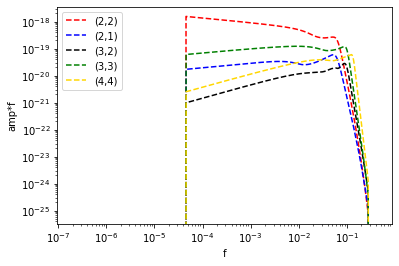

2 2
2 1
3 2
3 3
4 4


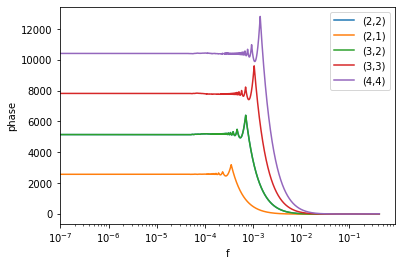

In [7]:
colors=['red','blue','black','green','gold']
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    tmp_amp= abs(hlm[l,m][1])
    tmp_phase =hlm[l,m][2]
    factor=1/2.* (lal.SpinWeightedSphericalHarmonic(inc,phi0,-2,l,m)+\
                 (-1)**l *np.conj(lal.SpinWeightedSphericalHarmonic(inc,phi0,-2,l,-m)))
    plt.loglog(tmp_phase.sample_frequencies,abs(tmp_amp*np.exp(1j*tmp_phase))*tmp_phase.sample_frequencies,label='(%d,%d)'%(l,m),color=colors[i],linestyle='--')
plt.legend()
plt.ylabel('amp*f')
plt.xlabel('f')
plt.show()

#################################################
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    tmp_amp= abs(hlm[l,m][1])
    tmp_phase =hlm[l,m][2]
    plt.semilogx(tmp_phase.sample_frequencies,tmp_phase,label='(%d,%d)'%(l,m))
plt.legend()
plt.ylabel('phase')
plt.xlabel('f')
plt.show()

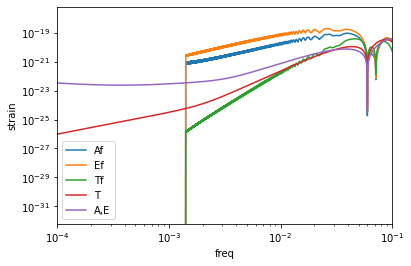

In [7]:
plt.loglog(fre,np.abs(Af*fre),label='Af',linestyle='-')
plt.loglog(fre,np.abs(Ef*fre),label='Ef',linestyle='-')
plt.loglog(fre,np.abs(Tf*fre),label='Tf',linestyle='-')
plt.loglog(PSD_TDIT.sample_frequencies,np.sqrt(PSD_TDIT*PSD_TDIT.sample_frequencies),label='T')
plt.loglog(PSD_TDIAE.sample_frequencies,np.sqrt(PSD_TDIAE*PSD_TDIAE.sample_frequencies),label='A,E')
plt.xlabel('freq')
plt.ylabel('strain')
plt.legend()
plt.xlim(1e-4,1e-1)
plt.show()



In [8]:
freqs, A,E,T =get_TDI(chirp_mass,q,DL,inc,phi0,chi1,chi2,lambd,beta,psi,t0,trajdict,TDItag,apx[1],modes[1])


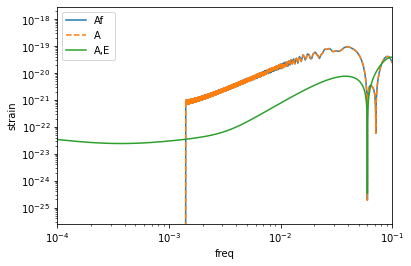

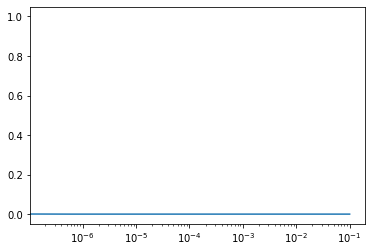

In [9]:
plt.loglog(fre,np.abs(Af*fre),label='Af',linestyle='-')
plt.loglog(freqs,np.abs(A*freqs),label='A',linestyle='--')
plt.loglog(PSD_TDIAE.sample_frequencies,np.sqrt(PSD_TDIAE*PSD_TDIAE.sample_frequencies),label='A,E')
plt.xlabel('freq')
plt.ylabel('strain')
plt.legend()
plt.xlim(1e-4,1e-1)
plt.show()
plt.semilogx(freqs,np.abs(A-Af)**freqs)

Compute SNR

In [10]:
TDIA= types.FrequencySeries(A,delta_f=freqs[1]-freqs[0])
TDIE= types.FrequencySeries(E,delta_f=freqs[1]-freqs[0])
TDIT= types.FrequencySeries(T,delta_f=freqs[1]-freqs[0])
tmp_A= copy.deepcopy(TDIA)
tmp_E= copy.deepcopy(TDIE)
tmp_T= copy.deepcopy(TDIT)

psdAE = interpolate(PSD_TDIAE,TDIA.delta_f)
psdT  = interpolate(PSD_TDIT,TDIT.delta_f)
print(TDIA.delta_f,TDIE.delta_f,TDIT.delta_f,psdAE.delta_f,psdT.delta_f)

SNR=sigmasq(TDIA,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-1)+\
    sigmasq(TDIE,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-1)+\
    sigmasq(TDIT,psd=psdT,low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-1)
print(np.sqrt(SNR))

2e-07 2e-07 2e-07 2e-07 2e-07
427.0809311627992


In [11]:
flen=int(1/2 /TDIA.delta_f) +1
print(flen,len(TDIA))
TDIA.resize(flen)
TDIE.resize(flen)
TDIT.resize(flen)
psdAE = interpolate(PSD_TDIAE,TDIA.delta_f)
psdT  = interpolate(PSD_TDIT,TDIT.delta_f)
print(TDIA.delta_f,TDIE.delta_f,TDIT.delta_f,psdAE.delta_f,psdT.delta_f)
#############
hh = sigmasq(TDIA,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
     sigmasq(TDIE,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1) +\
     sigmasq(TDIT,psd=psdT, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)

dh= matched_filter_core(TDIA,TDIA,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)[0]+\
    matched_filter_core(TDIE,TDIE,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)[0]+\
    matched_filter_core(TDIT,TDIT,psd=psdT,low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)[0]
dt=dh.sample_times
print(dt)
dh_tc=dh[0]

print('<d|h>-<h|h>/2,<d|h>,<h|h>/2',dh_tc.real*4*TDIA.delta_f-hh/2,dh_tc.real*4*TDIA.delta_f,hh/2)
#################################
df_hf=sigmasq(TDIA-TDIA,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
      sigmasq(TDIE-TDIE,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
      sigmasq(TDIT-TDIT,psd=psdT, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)
dd = sigmasq(TDIA,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
     sigmasq(TDIE,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1) +\
     sigmasq(TDIT,psd=psdT, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)
print('<d-h|d-h>/2,<d|d>',df_hf/2,dd)
print('-logL=(<d-h|d-h>-<dd>)/2',(df_hf-dd)/2)

2500001 500001
2e-07 2e-07 2e-07 2e-07 2e-07
[0.000000e+00 1.000000e+00 2.000000e+00 ... 4.999997e+06 4.999998e+06
 4.999999e+06]
<d|h>-<h|h>/2,<d|h>,<h|h>/2 91199.06088144174 182398.12176288353 91199.0608814418
<d-h|d-h>/2,<d|d> 0.0 182398.1217628836
-logL=(<d-h|d-h>-<dd>)/2 -91199.0608814418


In [12]:
#without HM modes
freqs, A_noHM,E_noHM,T_noHM =get_TDI(chirp_mass,q,DL,inc,phi0,chi1,chi2,lambd,beta,psi,t0,trajdict,TDItag,apx[1],modes[0])

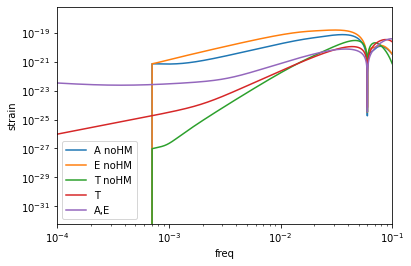

In [13]:
plt.loglog(freqs,np.abs(A_noHM*freqs),label='A noHM',linestyle='-')
plt.loglog(freqs,np.abs(E_noHM*freqs),label='E noHM',linestyle='-')
plt.loglog(freqs,np.abs(T_noHM*freqs),label='T noHM',linestyle='-')
plt.loglog(PSD_TDIT.sample_frequencies,np.sqrt(PSD_TDIT*PSD_TDIT.sample_frequencies),label='T')
plt.loglog(PSD_TDIAE.sample_frequencies,np.sqrt(PSD_TDIAE*PSD_TDIAE.sample_frequencies),label='A,E')
plt.xlabel('freq')
plt.ylabel('strain')
plt.legend()
plt.xlim(1e-4,1e-1)
plt.show()


In [14]:
TDIA_noHM= types.FrequencySeries(A_noHM,delta_f=freqs[1]-freqs[0])
TDIE_noHM= types.FrequencySeries(E_noHM,delta_f=freqs[1]-freqs[0])
TDIT_noHM= types.FrequencySeries(T_noHM,delta_f=freqs[1]-freqs[0])

SNR_noHM=sigmasq(TDIA_noHM,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-1)+\
    sigmasq(TDIE_noHM,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-1)+\
    sigmasq(TDIT_noHM,psd=psdT,low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-1)
print(np.sqrt(SNR_noHM))


428.5246442885575


In [15]:
flen=int(1/2 /TDIA.delta_f) +1
print(flen,len(TDIA))
TDIA_noHM.resize(flen)
TDIE_noHM.resize(flen)
TDIT_noHM.resize(flen)

print(TDIA_noHM.delta_f,TDIE_noHM.delta_f,TDIT_noHM.delta_f,psdAE.delta_f,psdT.delta_f)
#############
hh = sigmasq(TDIA_noHM,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
     sigmasq(TDIE_noHM,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1) +\
     sigmasq(TDIT_noHM,psd=psdT, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)

dh= matched_filter_core(TDIA_noHM,TDIA,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)[0]+\
    matched_filter_core(TDIE_noHM,TDIE,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)[0]+\
    matched_filter_core(TDIT_noHM,TDIT,psd=psdT,low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)[0]
dt=dh.sample_times
print(dt)
dh_tc=dh[0]

print('<d|h>-<h|h>/2,<d|h>,<h|h>/2',dh_tc.real*4*TDIA.delta_f-hh/2,dh_tc.real*4*TDIA.delta_f,hh/2)
df_hf=sigmasq(TDIA-TDIA_noHM,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
      sigmasq(TDIE-TDIE_noHM,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
      sigmasq(TDIT-TDIT_noHM,psd=psdT, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)
dd = sigmasq(TDIA,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
     sigmasq(TDIE,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1) +\
     sigmasq(TDIT,psd=psdT, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)
print('<d-h|d-h>/2,<d|d>',df_hf/2,dd)
print('-logL=(<d-h|d-h>-<dd>)/2',(df_hf-dd)/2)

2500001 2500001
2e-07 2e-07 2e-07 2e-07 2e-07
[0.000000e+00 1.000000e+00 2.000000e+00 ... 4.999997e+06 4.999998e+06
 4.999999e+06]
<d|h>-<h|h>/2,<d|h>,<h|h>/2 85318.51511746 177135.20049877738 91816.68538131738
<d-h|d-h>/2,<d|d> 5880.545763981812 182398.1217628836
-logL=(<d-h|d-h>-<dd>)/2 -85318.51511745999


2500001 500001
2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07
chirp mass= 49249.164742357876 loglr= 250052.43055265484 (<d-h|d-h>-<d|d>)/2 -250052.4305526549
<d|h>= 764025.931309971 <h|h>= 1027947.0015146324 <d-h|d-h>= 529115.292127874 <d|d>= 1029220.1532331838
2500001 500001
2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07
chirp mass= 49269.164742357876 loglr= 434413.4941461924 (<d-h|d-h>-<d|d>)/2 -434413.4941461924
<d|h>= 948709.0169512881 <h|h>= 1028591.0456101914 <d-h|d-h>= 160393.16494079903 <d|d>= 1029220.1532331838
2500001 500001
2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07
chirp mass= 49289.164742357876 loglr= 514610.07661659166 (<d-h|d-h>-<d|d>)/2 -514610.0766165919
<d|h>= 1029220.1532331835 <h|h>= 1029220.1532331838 <d-h|d-h>= 0.0 <d|d>= 1029220.1532331838
2500001 500001
2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07
chirp mass= 49309.164742357876 loglr= 434497.8126603491 (<d-h|d-h>-<d|d>)/2 -434497.8126603492
<d|h>= 949430.0451322359 <h|h>= 1029864.4649437735 <d-h|d-h>= 

/disk1/home/wangrj/anaconda2/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


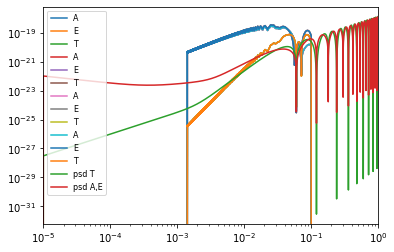

49289.164742357876


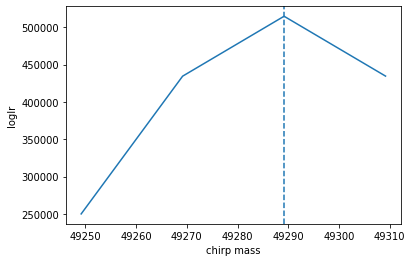

In [30]:

mchirp=np.arange(chirp_mass-40,chirp_mass+40,20)
loglr=[]
for i in range(len(mchirp)):
    dataA=copy.deepcopy(tmp_A)
    dataE=copy.deepcopy(tmp_E)
    dataT=copy.deepcopy(tmp_T)

    f1, A1,E1,T1 =get_TDI(mchirp[i],q,DL,inc,phi0,chi1,chi2,lambd,beta,psi,t0,trajdict,TDItag,apx[1],modes[1])
    TDIA1= types.FrequencySeries(A1,delta_f=f1[1]-f1[0])
    TDIE1= types.FrequencySeries(E1,delta_f=f1[1]-f1[0])
    TDIT1= types.FrequencySeries(T1,delta_f=f1[1]-f1[0])
    #########################################
    flen=int(1/2 /TDIA1.delta_f) +1
    print(flen,len(TDIA1))
    TDIA1.resize(flen)
    TDIE1.resize(flen)
    TDIT1.resize(flen)
    dataA.resize(flen)
    dataE.resize(flen)
    dataT.resize(flen)

    plt.loglog(TDIA1.sample_frequencies,np.abs(TDIA1*TDIA1.sample_frequencies),label='A(mchirp=%f)'%mchirp[i])
    plt.loglog(TDIE1.sample_frequencies,np.abs(TDIE1*TDIA1.sample_frequencies),label='E(mchirp=%f)'%mchirp[i])
    plt.loglog(TDIT1.sample_frequencies,np.abs(TDIT1*TDIA1.sample_frequencies),label='T(mchirp=%f)'%mchirp[i])
    
    psdAE = interpolate(PSD_TDIAE,TDIA1.delta_f)
    psdT  = interpolate(PSD_TDIT,TDIT1.delta_f)
    print(TDIA1.delta_f,TDIE1.delta_f,TDIT1.delta_f,dataA.delta_f,dataE.delta_f,dataT.delta_f,psdAE.delta_f,psdT.delta_f)

    ############################################
    hh = sigmasq(TDIA1,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
         sigmasq(TDIE1,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1) +\
         sigmasq(TDIT1,psd=psdT, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)
    dh= matched_filter_core(TDIA1,dataA,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)[0]+\
        matched_filter_core(TDIE1,dataE,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)[0]+\
        matched_filter_core(TDIT1,dataT,psd=psdT,low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)[0]
    #dt=dh.sample_times
    #dh_tc=dh[0]
    dh=dh[0].real*4*TDIA1.delta_f
    loglr.append(dh-hh/2)
    df_hf=sigmasq(dataA-TDIA1,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
          sigmasq(dataE-TDIE1,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
          sigmasq(dataT-TDIT1,psd=psdT, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)
    dd = sigmasq(dataA,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
         sigmasq(dataE,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1) +\
         sigmasq(dataT,psd=psdT, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)
    print('chirp mass=',mchirp[i],'loglr=',dh-hh/2,'(<d-h|d-h>-<d|d>)/2',(df_hf-dd)/2)
    print('<d|h>=',dh,'<h|h>=',hh,'<d-h|d-h>=',df_hf,'<d|d>=',dd)



plt.loglog(PSD_TDIT.sample_frequencies,np.sqrt(PSD_TDIT*PSD_TDIT.sample_frequencies),label='psd T')
plt.loglog(PSD_TDIAE.sample_frequencies,np.sqrt(PSD_TDIAE*PSD_TDIAE.sample_frequencies),label='psd A,E')
plt.legend(fontsize='8')
plt.xlim(1e-5,1)
plt.show()

plt.plot(mchirp,loglr)
plt.axvline(x=chirp_mass,linestyle='--')
plt.ylabel('loglr')
plt.xlabel('chirp mass')
inx=np.argmax(loglr)
print(mchirp[inx])

2500001 500001
2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07
chirp mass= 49249.164742357876 loglr= 233133.95102886437 (<d-h|d-h>-<d|d>)/2 -233133.95102886454
<d|h>= 746652.8813084537 <h|h>= 1027037.8605591787 <d-h|d-h>= 562952.2511754547 <d|d>= 1029220.1532331838
2500001 500001
2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07
chirp mass= 49269.164742357876 loglr= 411554.0884141406 (<d-h|d-h>-<d|d>)/2 -411554.08841414074
<d|h>= 925375.0942907517 <h|h>= 1027642.0117532222 <d-h|d-h>= 206111.97640490226 <d|d>= 1029220.1532331838
2500001 500001
2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07
chirp mass= 49289.164742357876 loglr= 486311.09765755624 (<d-h|d-h>-<d|d>)/2 -486311.09765755606
<d|h>= 1000434.2131014011 <h|h>= 1028246.2308876897 <d-h|d-h>= 56597.95791807165 <d|d>= 1029220.1532331838
2500001 500001
2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07 2e-07
chirp mass= 49309.164742357876 loglr= 411152.18125231244 (<d-h|d-h>-<d|d>)/2 -411152.18125231244
<d|h>= 925577.4401995558 <h|h>= 1028850.5

/disk1/home/wangrj/anaconda2/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


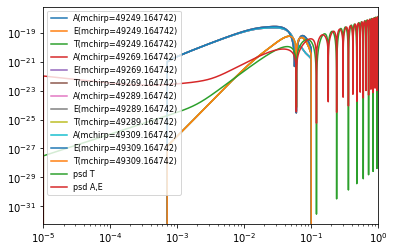

49289.164742357876


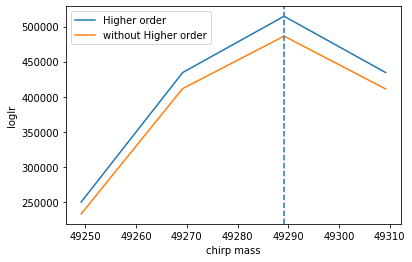

In [31]:

mchirp=np.arange(chirp_mass-40,chirp_mass+40,20)
loglr_noHM=[]
for i in range(len(mchirp)):
    dataA=copy.deepcopy(tmp_A)
    dataE=copy.deepcopy(tmp_E)
    dataT=copy.deepcopy(tmp_T)

    f1, A_noHM1,E_noHM1,T_noHM1 =get_TDI(mchirp[i],q,DL,inc,phi0,chi1,chi2,lambd,beta,psi,t0,trajdict,TDItag,apx[1],modes[0])
    TDIA_noHM1= types.FrequencySeries(A_noHM1,delta_f=f1[1]-f1[0])
    TDIE_noHM1= types.FrequencySeries(E_noHM1,delta_f=f1[1]-f1[0])
    TDIT_noHM1= types.FrequencySeries(T_noHM1,delta_f=f1[1]-f1[0])
    #########################################
    flen=int(1/2 /TDIA_noHM1.delta_f) +1
    print(flen,len(TDIA_noHM1))
    TDIA_noHM1.resize(flen)
    TDIE_noHM1.resize(flen)
    TDIT_noHM1.resize(flen)
    dataA.resize(flen)
    dataE.resize(flen)
    dataT.resize(flen)

    plt.loglog(TDIA_noHM1.sample_frequencies,np.abs(TDIA_noHM1*TDIA_noHM1.sample_frequencies),label='A(mchirp=%f)'%mchirp[i])
    plt.loglog(TDIE_noHM1.sample_frequencies,np.abs(TDIE_noHM1*TDIA_noHM1.sample_frequencies),label='E(mchirp=%f)'%mchirp[i])
    plt.loglog(TDIT_noHM1.sample_frequencies,np.abs(TDIT_noHM1*TDIA_noHM1.sample_frequencies),label='T(mchirp=%f)'%mchirp[i])
    
    psdAE = interpolate(PSD_TDIAE,TDIA_noHM1.delta_f)
    psdT  = interpolate(PSD_TDIT,TDIT_noHM1.delta_f)
    print(TDIA_noHM1.delta_f,TDIE_noHM1.delta_f,TDIT_noHM1.delta_f,dataA.delta_f,dataE.delta_f,dataT.delta_f,psdAE.delta_f,psdT.delta_f)

    ############################################
    hh = sigmasq(TDIA_noHM1,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
         sigmasq(TDIE_noHM1,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1) +\
         sigmasq(TDIT_noHM1,psd=psdT, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)
    dh= matched_filter_core(TDIA_noHM1,dataA,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)[0]+\
        matched_filter_core(TDIE_noHM1,dataE,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)[0]+\
        matched_filter_core(TDIT_noHM1,dataT,psd=psdT,low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)[0]
    #dt=dh.sample_times
    #dh_tc=dh[0]
    dh=dh[0].real*4*TDIA_noHM1.delta_f
    loglr_noHM.append(dh-hh/2)
    df_hf=sigmasq(dataA-TDIA_noHM1,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
          sigmasq(dataE-TDIE_noHM1,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
          sigmasq(dataT-TDIT_noHM1,psd=psdT, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)
    dd = sigmasq(dataA,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)+\
         sigmasq(dataE,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1) +\
         sigmasq(dataT,psd=psdT, low_frequency_cutoff=1e-4,high_frequency_cutoff=0.1)
    print('chirp mass=',mchirp[i],'loglr=',dh-hh/2,'(<d-h|d-h>-<d|d>)/2',(df_hf-dd)/2)
    print('<d|h>=',dh,'<h|h>=',hh,'<d-h|d-h>=',df_hf,'<d|d>=',dd)



plt.loglog(PSD_TDIT.sample_frequencies,np.sqrt(PSD_TDIT*PSD_TDIT.sample_frequencies),label='psd T')
plt.loglog(PSD_TDIAE.sample_frequencies,np.sqrt(PSD_TDIAE*PSD_TDIAE.sample_frequencies),label='psd A,E')
plt.legend(fontsize='8')
plt.xlim(1e-5,1)
plt.show()

plt.plot(mchirp,loglr,label='Higher order')
plt.plot(mchirp,loglr_noHM,label='without Higher order')
plt.axvline(x=chirp_mass,linestyle='--')
plt.ylabel('loglr')
plt.xlabel('chirp mass')
plt.legend()
inx=np.argmax(loglr)
print(mchirp[inx])

The low-frequency limit

220000.00000000006
m10,m20 20.000000000000007 2.000000000000001
flow 2.272727272727272
rescale 10000.0
Fs 0.002


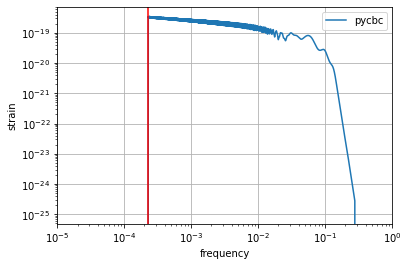

In [8]:
apx=['SEOBNRv4HM','IMRPhenomXHM']
modes=[[[2,2]],[[2,2],[2,1],[3,2],[3,3],[4,4]]] 
m10=m1=mass1_from_mchirp_q(chirp_mass,q)
m20=m2=mass2_from_mchirp_q(chirp_mass,q)
M1=m1+ m2 
print(M1)
#m1 >m2


while(m10>100):
    m10=m10/10
if(m10>50):
    m10=m10/4
m20=m10/q
print('m10,m20',m10,m20)
M0=m10+m20
flower=50/M0
print('flow',flower)
rescale=M1/M0
print('rescale',rescale)
Fs=(2e-07)*rescale
print('Fs',Fs)

hpf, hcf = get_fd_waveform(approximant=apx[1],
                         mass1=m10,
                         mass2=m20,
                         spin1z=chi1,
                         spin2z=chi2,
                         distance=DL,
                         inclination=inc,
                         coa_phase=phi0,
                         delta_f=Fs,
                         f_lower=flower,
                         mode_array=modes[1])

#rescale the time/frequency and amplitude
hpf=types.FrequencySeries(hpf.data.data[:],delta_f=hpf.delta_f/rescale)*rescale**2
hcf=types.FrequencySeries(hcf.data.data[:],delta_f=hcf.delta_f/rescale)*rescale**2


plt.loglog(hpf.sample_frequencies,abs(hpf)*hpf.sample_frequencies,label='pycbc')
plt.axvline(x=flower/rescale,color='red')
plt.xlabel('frequency')
plt.ylabel('strain')
plt.xlim(1e-5,1)
plt.legend()
plt.grid()
plt.show()

In [9]:
def FLISA(t,lambd,beta,psi,t0):
    alpha= 2*np.pi*(t-t0)      #t,t0: yr
    #print(alpha)
    beta_L= np.arcsin(np.cos(np.pi/3)*np.sin(beta)-np.sin(np.pi/3)*np.cos(beta)*np.cos(lambd-alpha))
    lambd_L= arctan(np.cos(beta)*np.cos(lambd)*(np.cos(np.pi/3)*np.cos(alpha)**2+np.sin(alpha)**2)+\
                    np.cos(beta)*np.sin(lambd)*np.cos(alpha)*np.sin(alpha)*(np.cos(np.pi/3)-1)+\
                    np.sin(np.pi/3)*np.sin(beta)*np.cos(alpha)+\
                    np.cos(beta)*np.sin(lambd)*(np.cos(np.pi/3)*np.sin(alpha)**2+np.cos(alpha)**2)+\
                    np.cos(beta)*np.cos(lambd)*np.cos(alpha)*np.sin(alpha)*(np.cos(np.pi/3)-1)+
                    np.sin(np.pi/3)*np.sin(beta)*np.sin(alpha))
    psi_L= psi +np.arctan(np.cos(pi/3)*np.cos(beta)+np.sin(np.pi/3)*np.sin(beta)*np.cos(lambd-alpha)-np.sin(np.pi/3)*np.sin(lambd-alpha))

    F_a_plus = (1+np.sin(beta_L)**2)*np.cos(2*lambd_L-np.pi/3)/2
    F_a_cross = np.sin(beta_L)*np.sin(2*lambd_L-np.pi/3)
    F_e_plus = (1+np.sin(beta_L)**2)*np.cos(2*lambd_L+np.pi/6)/2
    F_e_cross = np.sin(beta_L)*np.sin(2*lambd_L+np.pi/6)
    #include the polarization angle in the pattern function
    Fa_plus = np.cos(2*psi_L)*F_a_plus + np.sin(2*psi_L) *F_a_cross
    Fe_plus = np.cos(2*psi_L)*F_e_plus + np.sin(2*psi_L) *F_e_cross
    Fa_cross = -np.sin(2*psi_L)*F_a_plus + np.cos(2*psi_L) *F_a_cross
    Fe_cross = -np.sin(2*psi_L)*F_e_plus + np.cos(2*psi_L) *F_e_cross
    return Fa_plus,Fa_cross,Fe_plus,Fe_cross


In [10]:
#sum of all modes
TDIA_int= np.zeros(len(freqs_SMBH), dtype='complex128')
TDIE_int= np.zeros(len(freqs_SMBH), dtype='complex128')
TDIT_int= np.zeros(len(freqs_SMBH), dtype='complex128')
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    TDIA_int += wftdiAET_int[l,m]['TDI1']
    TDIE_int += wftdiAET_int[l,m]['TDI2']
    TDIT_int += wftdiAET_int[l,m]['TDI3']
L= 2.5e9/LC.c
#we have eliminated frequency-dependent prefactors that are common to the signal 
# and to the noise by introducing the rescalings
TDIa = np.exp(-1j*(2*np.pi*freqs_SMBH*L))/(1j*np.sqrt(2)*np.sin(2*np.pi*freqs_SMBH*L)) *TDIA_int
TDIe = np.exp(-1j*(2*np.pi*freqs_SMBH*L))/(1j*np.sqrt(2)*np.sin(2*np.pi*freqs_SMBH*L)) *TDIE_int
TDIt = np.exp(-1j*(3*np.pi*freqs_SMBH*L))/(2*np.sqrt(2)*np.sin(np.pi*freqs_SMBH*L)*np.sin(2*np.pi*freqs_SMBH*L)) *TDIT_int
#To make the connection between these reduced TDI observables and the gravitational strain, more familiar in 
# the context of ground-based intruments, we also introduce the notations
h_a =TDIa /(-1j*6*np.pi*freqs_SMBH*L)
h_e =TDIe /(-1j*6*np.pi*freqs_SMBH*L)
h_t =TDIt /(-1j*6*np.pi*freqs_SMBH*L)

#sum of all modes
Nf = int (fnyquist_SMBH/df +1)
fre = df*np.arange(Nf)
i_b = int(np.rint(freqs_SMBH[0]/df))
print(Nf,f0,fre[i_b])
haf = np.zeros(Nf, dtype='complex128')
hef = np.zeros(Nf, dtype='complex128')
htf = np.zeros(Nf, dtype='complex128')


haf[i_b:len(freqs_SMBH)+ i_b] = h_a 
hef[i_b:len(freqs_SMBH)+i_b]  = h_e
htf[i_b:len(freqs_SMBH)+i_b]  = h_t
haf= types.FrequencySeries(haf,delta_f=fre[1]-fre[0])
hef= types.FrequencySeries(haf,delta_f=fre[1]-fre[0])
htf= types.FrequencySeries(htf,delta_f=fre[1]-fre[0])



2 2
2 1
3 2
3 3
4 4
500001 0.0014102 0.0014102


In [35]:
L

8.3391023799538

In [11]:
#Scaling out the same square factors from the noise power spectral density (PSD)
del_f= 1e-6
f= np.arange(1e-5,1.0,del_f)
flen = int(1.0/del_f)+1
flow=1e-5
PSD_TDIT= noisepsd_T(f)
PSD_TDIAE= noisepsd_AE(f)
L= 2.5e9/LC.c
PSD_TDIae= PSD_TDIAE/(2*np.sin(2*np.pi*f*L)**2)
PSD_TDIt= PSD_TDIT/(8*np.sin(np.pi*f*L)**2*np.sin(2*np.pi*f*L)**2)
#We can define a strain-like noise PSD
PSD_TDIae= PSD_TDIae/(6*np.pi*f*L)**2
PSD_TDIt= PSD_TDIt/(6*np.pi*f*L)**2

PSD_TDIt = from_numpy_arrays(f, PSD_TDIt, flen, del_f,flow)
PSD_TDIae = from_numpy_arrays(f, PSD_TDIae, flen, del_f,flow)

<function matplotlib.pyplot.show(*args, **kw)>

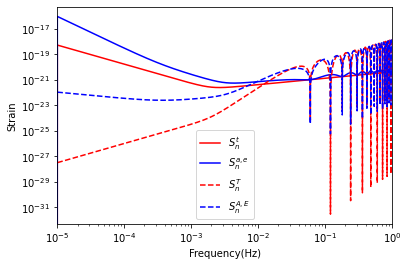

In [12]:
plt.loglog(PSD_TDIt.sample_frequencies,np.sqrt(PSD_TDIt*PSD_TDIt.sample_frequencies),linestyle='-',color='red',label='$S^{t}_{n}$')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),linestyle='-',color='blue',label='$S^{a,e}_{n}$')
plt.loglog(f,np.sqrt(PSD_TDIT*f),linestyle='--',color='red',label='$S^{T}_{n}$')
plt.loglog(f,np.sqrt(PSD_TDIAE*f),linestyle='--',color='blue',label='$S^{A,E}_{n}$')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Strain')
plt.xlim(1e-5,1e0)
plt.legend()
plt.savefig('PSD_TDI.pdf',dpi=300)
plt.show

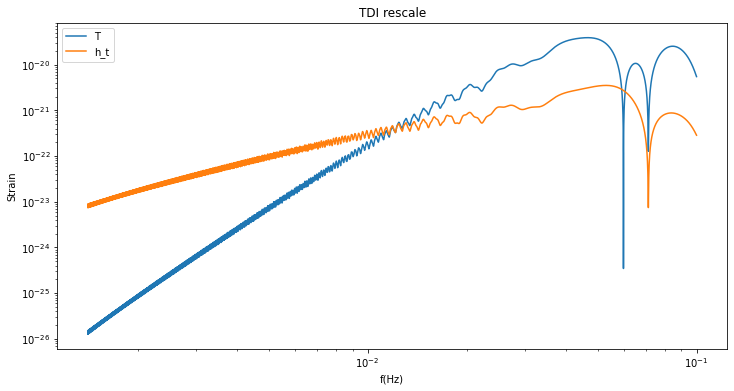

In [21]:
f, ax = plt.subplots(1, 1, figsize=[12,6])
#plt.loglog(freqs_SMBH,np.abs(TDIA_int*freqs_SMBH),label='A',linestyle='-')
#plt.loglog(freqs_SMBH,np.abs(h_a*freqs_SMBH),label='h_a',linestyle='-')
#plt.loglog(haf.sample_frequencies,np.abs(haf*haf.sample_frequencies),label='h_a(f)',linestyle='-')
#plt.loglog(freqs_SMBH,np.abs(TDIE_int*freqs_SMBH),label='E',linestyle='-')
#plt.loglog(freqs_SMBH,np.abs(h_e*freqs_SMBH),label='h_e',linestyle='-')
plt.loglog(freqs_SMBH,np.abs(TDIT_int*freqs_SMBH),label='T',linestyle='-')
plt.loglog(freqs_SMBH,np.abs(h_t*freqs_SMBH),label='h_t',linestyle='-')


plt.xlabel('f(Hz)')
plt.ylabel('Strain')
#plt.xlim(1e-5,1e-1)
#plt.ylim(1e-30,1e-18)
plt.title('TDI rescale')
plt.legend()
plt.show()

0.3619124183022121 -0.15670916898600123 -0.14801351971272367 0.38053263947789234
(-1.0674518837525802e-18+5.061276188951706e-19j)


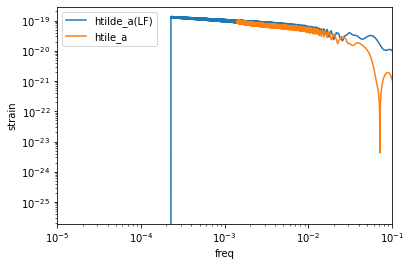

In [27]:

fre,hpf,hcf = gen_signal_fre(chirp_mass,q,DL,inc,phi0,chi1,chi2,apx[1],modes[1])
Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(t0,lambd,beta,psi,0)
htilde_a = Fa_plus*hpf + Fa_cross*hcf
htilde_e = Fe_plus*hpf + Fe_cross*hcf
tmp_ha= copy.deepcopy(htilde_a)
tmp_he= copy.deepcopy(htilde_e)

print(Fa_plus,Fa_cross,Fe_plus,Fe_cross)
print(htilde_a[100000])
#plt.loglog(haf.sample_frequencies,np.abs(haf*haf.sample_frequencies),label='htile_a',linestyle='-')

#plt.loglog(freqs_SMBH,np.abs(h_t*freqs_SMBH),label='t',linestyle='-')
plt.loglog(htilde_a.sample_frequencies,abs(htilde_a)*htilde_a.sample_frequencies,label='htilde_a(LF)')
#plt.loglog(htilde_e.sample_frequencies,abs(htilde_e)*htilde_e.sample_frequencies,label='htilde_e(LF)')
plt.loglog(freqs_SMBH,np.abs(h_a*freqs_SMBH),label='htile_a',linestyle='-')
#plt.loglog(freqs_SMBH,np.abs(h_e*freqs_SMBH),label='htile_e',linestyle='-')
plt.axvline(x=0.12)
plt.legend()
plt.xlim(1e-5,1e-1)
#plt.ylim(1e-26,1e-17)
plt.xlabel('freq')
plt.ylabel('strain')
plt.show()





2500001 2097153
2e-07 2e-07 2e-07 2e-07 2e-07
chirp mass= 49287.664742357876 loglr= 568261.4304086561 (<d-h|d-h>-<d|d>)/2 -568261.4304086562
<d|h>= 1138456.0981922487 <h|h>= 1140389.3355671852 <d-h|d-h>= 3934.7665041119435 <d|d>= 1140457.6273214244
2500001 2097153
1.9999999999999996e-07 1.9999999999999996e-07 2e-07 2e-07 1.9999999999999996e-07
chirp mass= 49288.164742357876 loglr= 569349.2963916922 (<d-h|d-h>-<d|d>)/2 -569349.2963916925
<d|h>= 1139556.457065018 <h|h>= 1140414.3213466513 <d-h|d-h>= 1759.0345380391084 <d|d>= 1140457.627321424
2500001 2097153
2e-07 2e-07 2e-07 2e-07 2e-07
chirp mass= 49288.664742357876 loglr= 570008.1584104779 (<d-h|d-h>-<d|d>)/2 -570008.1584104778
<d|h>= 1140226.7055852062 <h|h>= 1140437.0943494565 <d-h|d-h>= 441.3105004687135 <d|d>= 1140457.6273214244
2500001 2097153
2e-07 2e-07 2e-07 2e-07 2e-07
chirp mass= 49289.164742357876 loglr= 570228.813660712 (<d-h|d-h>-<d|d>)/2 -570228.8136607122
<d|h>= 1140457.6273214242 <h|h>= 1140457.6273214244 <d-h|d-h>= 0.

/disk1/home/wangrj/anaconda2/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


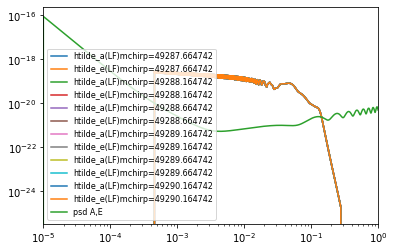

49289.164742357876


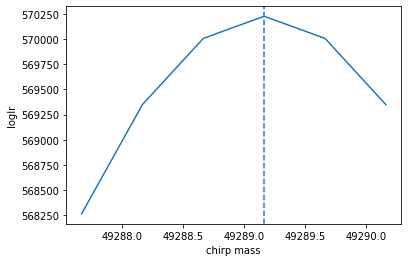

In [43]:

mchirp=np.arange(chirp_mass-1.5,chirp_mass+1.5,0.5)
loglr=[]
for i in range(len(mchirp)):
    dataA=copy.deepcopy(tmp_ha)
    dataE=copy.deepcopy(tmp_he)
    f,hpf,hcf = gen_signal_fre(mchirp[i],q,DL,inc,phi0,chi1,chi2,apx[1],modes[1])
  

    Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(t0,lambd,beta,psi,0)
    htilde_a = Fa_plus*hpf + Fa_cross*hcf
    htilde_e = Fe_plus*hpf + Fe_cross*hcf
    #########################################
    flen=int(1/2 /dataA.delta_f) +1
    print(flen,len(dataA))
    htilde_a.resize(flen)
    htilde_e.resize(flen)
    dataA.resize(flen)
    dataE.resize(flen)

    plt.loglog(htilde_a.sample_frequencies,abs(htilde_a)*htilde_e.sample_frequencies,label='htilde_a(LF)mchirp=%f'%mchirp[i])
    plt.loglog(htilde_e.sample_frequencies,abs(htilde_e)*htilde_e.sample_frequencies,label='htilde_e(LF)mchirp=%f'%mchirp[i])

    psdAE = interpolate(PSD_TDIae,htilde_a.delta_f)
  
    print(htilde_a.delta_f,htilde_e.delta_f,dataA.delta_f,dataE.delta_f,psdAE.delta_f)

    ############################################
    flow=1e-4
    fhigh=1e-2
    hh = sigmasq(htilde_a,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)+\
         sigmasq(htilde_e,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh) 
    
    dh= matched_filter_core(htilde_a,dataA,psd=psdAE,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)[0]+\
        matched_filter_core(htilde_e,dataE,psd=psdAE,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)[0]
    #dt=dh.sample_times
    #dh_tc=dh[0]
    dh=dh[0].real*4*htilde_a.delta_f
    loglr.append(dh-hh/2)
    df_hf=sigmasq(dataA-htilde_a,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)+\
          sigmasq(dataE-htilde_e,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
    dd = sigmasq(dataA,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)+\
         sigmasq(dataE,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
    print('chirp mass=',mchirp[i],'loglr=',dh-hh/2,'(<d-h|d-h>-<d|d>)/2',(df_hf-dd)/2)
    print('<d|h>=',dh,'<h|h>=',hh,'<d-h|d-h>=',df_hf,'<d|d>=',dd)




plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='psd A,E')
plt.legend(fontsize='8')
plt.xlim(1e-5,1)
plt.show()

plt.plot(mchirp,loglr)
plt.axvline(x=chirp_mass,linestyle='--')
plt.ylabel('loglr')
plt.xlabel('chirp mass')
inx=np.argmax(loglr)
print(mchirp[inx])

2500001 2097153
2e-07 2e-07 2e-07 2e-07 2e-07
chirp mass= 49287.664742357876 loglr= 559880.91392264 (<d-h|d-h>-<d|d>)/2 -559880.91392264
<d|h>= 1111514.282018741 <h|h>= 1103266.7361922017 <d-h|d-h>= 20695.799476144428 <d|d>= 1140457.6273214244
2500001 2097153
1.9999999999999996e-07 1.9999999999999996e-07 2e-07 2e-07 1.9999999999999996e-07
chirp mass= 49288.164742357876 loglr= 560897.8148325204 (<d-h|d-h>-<d|d>)/2 -560897.8148325206
<d|h>= 1112539.4464025695 <h|h>= 1103283.2631400982 <d-h|d-h>= 18661.997656382853 <d|d>= 1140457.627321424
2500001 2097153
2e-07 2e-07 2e-07 2e-07 2e-07
chirp mass= 49288.664742357876 loglr= 561508.9409565062 (<d-h|d-h>-<d|d>)/2 -561508.9409565062
<d|h>= 1113158.8360266753 <h|h>= 1103299.7901403382 <d-h|d-h>= 17439.745408412142 <d|d>= 1140457.6273214244
2500001 2097153
2e-07 2e-07 2e-07 2e-07 2e-07
chirp mass= 49289.164742357876 loglr= 561707.371745662 (<d-h|d-h>-<d|d>)/2 -561707.3717456621
<d|h>= 1113365.530342123 <h|h>= 1103316.317192922 <d-h|d-h>= 17042.8

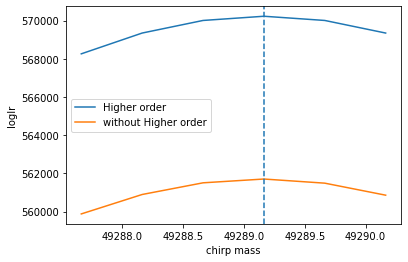

In [44]:
mchirp=np.arange(chirp_mass-1.5,chirp_mass+1.5,0.5)
loglr_noHM=[]
for i in range(len(mchirp)):
    dataA=copy.deepcopy(tmp_ha)
    dataE=copy.deepcopy(tmp_he)
    f,hpf_noHM,hcf_noHM = gen_signal_fre(mchirp[i],q,DL,inc,phi0,chi1,chi2,apx[1],modes[0])
  

    Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(t0,lambd,beta,psi,0)
    htilde_a_noHM = Fa_plus*hpf_noHM + Fa_cross*hcf_noHM
    htilde_e_noHM = Fe_plus*hpf_noHM + Fe_cross*hcf_noHM
    #########################################
    flen=int(1/2 /dataA.delta_f) +1
    print(flen,len(dataA))
    htilde_a_noHM.resize(flen)
    htilde_e_noHM.resize(flen)
    dataA.resize(flen)
    dataE.resize(flen)

    #plt.loglog(htilde_a.sample_frequencies,abs(htilde_a)*htilde_e.sample_frequencies,label='htilde_a(LF)')
    #plt.loglog(htilde_e.sample_frequencies,abs(htilde_e)*htilde_e.sample_frequencies,label='htilde_e(LF)')

    psdAE = interpolate(PSD_TDIae,htilde_a_noHM.delta_f)
  
    print(htilde_a_noHM.delta_f,htilde_e_noHM.delta_f,dataA.delta_f,dataE.delta_f,psdAE.delta_f)

    ############################################
    hh = sigmasq(htilde_a_noHM,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-2)+\
         sigmasq(htilde_e_noHM,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-2) 
    
    dh= matched_filter_core(htilde_a_noHM,dataA,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-2)[0]+\
        matched_filter_core(htilde_e_noHM,dataE,psd=psdAE,low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-2)[0]
    #dt=dh.sample_times
    #dh_tc=dh[0]
    dh=dh[0].real*4*htilde_a_noHM.delta_f
    loglr_noHM.append(dh-hh/2)
    df_hf=sigmasq(dataA-htilde_a_noHM,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-2)+\
          sigmasq(dataE-htilde_e_noHM,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-2)
    dd = sigmasq(dataA,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-2)+\
         sigmasq(dataE,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-2)
    print('chirp mass=',mchirp[i],'loglr=',dh-hh/2,'(<d-h|d-h>-<d|d>)/2',(df_hf-dd)/2)
    print('<d|h>=',dh,'<h|h>=',hh,'<d-h|d-h>=',df_hf,'<d|d>=',dd)




#plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='psd A,E')
#plt.legend(fontsize='8')
#plt.xlim(1e-5,1)
#plt.show()

plt.plot(mchirp,loglr,label='Higher order')
plt.plot(mchirp,loglr_noHM,label='without Higher order')
plt.axvline(x=chirp_mass,linestyle='--')
plt.ylabel('loglr')
plt.xlabel('chirp mass')
plt.legend()
inx=np.argmax(loglr)
print(mchirp[inx])

2500001 2097153
1.9999999999999996e-07 1.9999999999999996e-07 2e-07 2e-07 1.9999999999999996e-07
q= 9.999 loglr= -73019.03336113371 (<d-h|d-h>-<d|d>)/2 73019.03336113389
<d|h>= 497222.7636908432 <h|h>= 1140483.5941039538 <d-h|d-h>= 1286495.6940436917 <d|d>= 1140457.627321424
2500001 2097153
2e-07 2e-07 2e-07 2e-07 2e-07
q= 9.99925 loglr= 190794.66949172097 (<d-h|d-h>-<d|d>)/2 -190794.66949172108
<d|h>= 761036.8283646749 <h|h>= 1140484.317745908 <d-h|d-h>= 758868.2883379823 <d|d>= 1140457.6273214244
2500001 2097153
1.9999999999999996e-07 1.9999999999999996e-07 2e-07 2e-07 1.9999999999999996e-07
q= 9.9995 loglr= 395809.6054346353 (<d-h|d-h>-<d|d>)/2 -395809.60543463536
<d|h>= 966049.7307688992 <h|h>= 1140480.2506685278 <d-h|d-h>= 348838.41645215324 <d|d>= 1140457.627321424
2500001 2097153
2e-07 2e-07 2e-07 2e-07 2e-07
q= 9.999749999999999 loglr= 525737.5156934687 (<d-h|d-h>-<d|d>)/2 -525737.5156934689
<d|h>= 1095973.3154103856 <h|h>= 1140471.5994338337 <d-h|d-h>= 88982.59593448663 <d|d>=

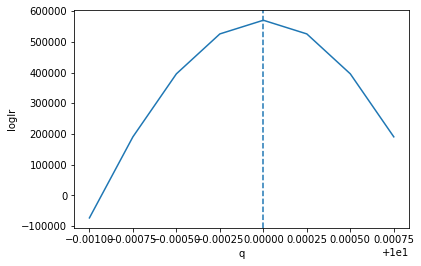

In [35]:


q_=np.arange(q-0.001,q+0.001,0.00025)
loglr=[]
for i in range(len(q_)):
    dataA=copy.deepcopy(tmp_ha)
    dataE=copy.deepcopy(tmp_he)
    f,hpf,hcf = gen_signal_fre(chirp_mass,q_[i],DL,inc,phi0,chi1,chi2,apx[1],modes[1])
  

    Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(t0,lambd,beta,psi,0)
    htilde_a = Fa_plus*hpf + Fa_cross*hcf
    htilde_e = Fe_plus*hpf + Fe_cross*hcf
    #########################################
    flen=int(1/2 /dataA.delta_f) +1
    print(flen,len(dataA))
    htilde_a.resize(flen)
    htilde_e.resize(flen)
    dataA.resize(flen)
    dataE.resize(flen)

    #plt.loglog(htilde_a.sample_frequencies,abs(htilde_a)*htilde_e.sample_frequencies,label='htilde_a(LF)mchirp=%f'%mchirp[i])
    #plt.loglog(htilde_e.sample_frequencies,abs(htilde_e)*htilde_e.sample_frequencies,label='htilde_e(LF)mchirp=%f'%mchirp[i])

    psdAE = interpolate(PSD_TDIae,htilde_a.delta_f)
  
    print(htilde_a.delta_f,htilde_e.delta_f,dataA.delta_f,dataE.delta_f,psdAE.delta_f)

    ############################################
    flow=1e-4
    fhigh=1e-2
    hh = sigmasq(htilde_a,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)+\
         sigmasq(htilde_e,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh) 
    
    dh= matched_filter_core(htilde_a,dataA,psd=psdAE,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)[0]+\
        matched_filter_core(htilde_e,dataE,psd=psdAE,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)[0]
    #dt=dh.sample_times
    #dh_tc=dh[0]
    dh=dh[0].real*4*htilde_a.delta_f
    loglr.append(dh-hh/2)
    df_hf=sigmasq(dataA-htilde_a,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)+\
          sigmasq(dataE-htilde_e,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
    dd = sigmasq(dataA,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)+\
         sigmasq(dataE,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
    print('q=',q_[i],'loglr=',dh-hh/2,'(<d-h|d-h>-<d|d>)/2',(df_hf-dd)/2)
    print('<d|h>=',dh,'<h|h>=',hh,'<d-h|d-h>=',df_hf,'<d|d>=',dd)




# plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='psd A,E')
# plt.legend(fontsize='8')
# plt.xlim(1e-5,1)
# plt.show()

plt.plot(q_,loglr)
plt.axvline(x=q,linestyle='--')
plt.ylabel('loglr')
plt.xlabel('q')
inx=np.argmax(loglr)
print(q_[inx])

2500001 2097153
2e-07 2e-07 2e-07 2e-07 2e-07
lambda 0.5 loglr= -252619.30410415013 (<d-h|d-h>-<d|d>)/2 252619.3041041505
<d|h>= -5740.148840333667 <h|h>= 493758.31052763294 <d-h|d-h>= 1097922.223363188 <d|d>= 592683.6151548871
2500001 2097153
2e-07 2e-07 2e-07 2e-07 2e-07
lambda 1.0 loglr= -183751.21503534084 (<d-h|d-h>-<d|d>)/2 183751.21503534092
<d|h>= -21018.522430574314 <h|h>= 325465.38520953304 <d-h|d-h>= 960186.0452255689 <d|d>= 592683.6151548871
2500001 2097153
2e-07 2e-07 2e-07 2e-07 2e-07
lambda 1.5 loglr= -125351.24232700295 (<d-h|d-h>-<d|d>)/2 125351.2423270031
<d|h>= -56526.63036394453 <h|h>= 137649.22392611686 <d-h|d-h>= 843386.0998088933 <d|d>= 592683.6151548871
2500001 2097153
2e-07 2e-07 2e-07 2e-07 2e-07
lambda 2.0 loglr= -219721.61774560536 (<d-h|d-h>-<d|d>)/2 219721.61774560553
<d|h>= -169117.28789603204 <h|h>= 101208.65969914662 <d-h|d-h>= 1032126.8506460981 <d|d>= 592683.6151548871
2500001 2097153
2e-07 2e-07 2e-07 2e-07 2e-07
lambda 2.5 loglr= -501299.3392815074 

/disk1/home/wangrj/anaconda2/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


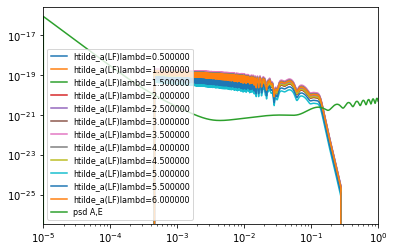

3.5


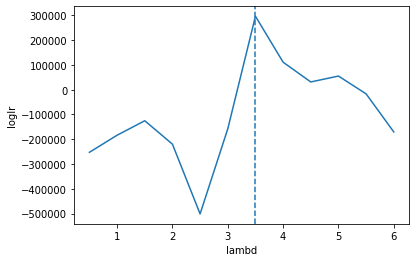

In [20]:

tmp_lambd=np.arange(lambd-3,lambd+3,0.5)
loglr=[]
for i in range(len(tmp_lambd)):
    dataA=copy.deepcopy(tmp_ha)
    dataE=copy.deepcopy(tmp_he)
    f,hpf,hcf = gen_signal_fre(chirp_mass,q,DL,inc,phi0,chi1,chi2,apx[1],modes[1])
  

    Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(t0,tmp_lambd[i],beta,psi,0)
    htilde_a = Fa_plus*hpf + Fa_cross*hcf
    htilde_e = Fe_plus*hpf + Fe_cross*hcf
    #########################################
    flen=int(1/2 /dataA.delta_f) +1
    print(flen,len(dataA))
    htilde_a.resize(flen)
    htilde_e.resize(flen)
    dataA.resize(flen)
    dataE.resize(flen)

    plt.loglog(htilde_a.sample_frequencies,abs(htilde_a)*htilde_e.sample_frequencies,label='htilde_a(LF)lambd=%f'%tmp_lambd[i])
    # plt.loglog(htilde_e.sample_frequencies,abs(htilde_e)*htilde_e.sample_frequencies,label='htilde_e(LF)')

    psdAE = interpolate(PSD_TDIae,htilde_a.delta_f)
  
    print(htilde_a.delta_f,htilde_e.delta_f,dataA.delta_f,dataE.delta_f,psdAE.delta_f)

    ############################################
    flow=1e-4
    fhigh=1e-1
    hh = sigmasq(htilde_a,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)+\
         sigmasq(htilde_e,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh) 
    
    dh= matched_filter_core(htilde_a,dataA,psd=psdAE,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)[0]+\
        matched_filter_core(htilde_e,dataE,psd=psdAE,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)[0]
    #dt=dh.sample_times
    #dh_tc=dh[0]
    dh=dh[0].real*4*htilde_a.delta_f
    loglr.append(dh-hh/2)
    df_hf=sigmasq(dataA-htilde_a,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)+\
          sigmasq(dataE-htilde_e,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
    dd = sigmasq(dataA,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)+\
         sigmasq(dataE,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
    print('lambda',tmp_lambd[i],'loglr=',dh-hh/2,'(<d-h|d-h>-<d|d>)/2',(df_hf-dd)/2)
    print('<d|h>=',dh,'<h|h>=',hh,'<d-h|d-h>=',df_hf,'<d|d>=',dd)


plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='psd A,E')
plt.legend(fontsize='8')
plt.xlim(1e-5,1)
plt.show()



plt.plot(tmp_lambd,loglr)
plt.axvline(x=lambd,linestyle='--')
plt.ylabel('loglr')
plt.xlabel('lambd')
inx=np.argmax(loglr)
print(tmp_lambd[inx])

In [99]:
Mc, q1,dis,iota =49284.79271484992 , 9.999776070073619,  6906.020625844414 , 3.0565243425493143
print(Mc, q1,dis,iota)
print(phi0,chi1,chi2,lambd,beta,psi,t0)
loglr=[]
dataA=copy.deepcopy(tmp_ha)
dataE=copy.deepcopy(tmp_he)

f,hpf_noHM,hcf_noHM = gen_signal_fre(Mc,q1,dis,iota,phi0,chi1,chi2,apx[1],modes[0],df=2e-7)

Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(t0,lambd,beta,psi,0)
print(Fa_plus,Fa_cross,Fe_plus,Fe_cross)
htilde_a_noHM = Fa_plus*hpf_noHM + Fa_cross*hcf_noHM
htilde_e_noHM = Fe_plus*hpf_noHM + Fe_cross*hcf_noHM

#########################################
flen=int(1/2 /dataA.delta_f) +1
print(flen,len(dataA),len(htilde_a_noHM))
htilde_a_noHM.resize(flen)
htilde_e_noHM.resize(flen)
dataA.resize(flen)
dataE.resize(flen)

#plt.loglog(htilde_a.sample_frequencies,abs(htilde_a)*htilde_e.sample_frequencies,label='htilde_a(LF)')
#plt.loglog(htilde_e.sample_frequencies,abs(htilde_e)*htilde_e.sample_frequencies,label='htilde_e(LF)')

psdAE = interpolate(PSD_TDIae,dataA.delta_f)
print(psdAE,len(psdAE))
print(htilde_a_noHM.delta_f,htilde_e_noHM.delta_f,dataA.delta_f,dataE.delta_f,psdAE.delta_f)

############################################
flow=9.999999999999999e-05 
fhigh=0.01
print(psdAE[100000])
print(htilde_a_noHM[100000]/psdAE[100000])
print(dataA[100000]/psdAE[100000])
hh = sigmasq(htilde_a_noHM,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)+\
    sigmasq(htilde_e_noHM,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh) 
print(sigmasq(htilde_a_noHM,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)/2)    
dh= matched_filter_core(htilde_a_noHM,dataA,psd=psdAE,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)[0]+\
    matched_filter_core(htilde_e_noHM,dataE,psd=psdAE,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)[0]
dh1= matched_filter_core(htilde_a_noHM,dataA,psd=psdAE,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)[0]*4*htilde_a_noHM.delta_f
print(dh1[0].real)

dh=dh[0].real*4*htilde_a_noHM.delta_f
loglr.append(dh-hh/2)
df_hf=sigmasq(dataA-htilde_a_noHM,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)+\
    sigmasq(dataE-htilde_e_noHM,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
dd = sigmasq(dataA,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-2)+\
    sigmasq(dataE,psd=psdAE, low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-2)
print('chirp mass=',Mc,'loglr=',dh-hh/2,'(<d-h|d-h>-<d|d>)/2',(df_hf-dd)/2)
print('<d|h>=',dh,'<h|h>=',hh/2,'<d-h|d-h>=',df_hf/2,'<d|d>=',dd)



49284.79271484992 9.999776070073619 6906.020625844414 3.0565243425493143
0.0 0.0 0.0 3.5 0.07079632679489656 0.8 0.05
-0.11196122023027277 0.8926899552728087 -0.8946599622838689 -0.11673404356467515
2500001 2097153 2097153
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.38045299e-41
 2.38043881e-41 2.38042462e-41] 5000001
2e-07 2e-07 2e-07 2e-07 2e-07
4.071346446843661e-41
(-2.1679702230544822e+17+2.6972178724129206e+17j)
(-8.214279088513947e+22+4.569871233549268e+22j)
3.693463346687194e-06
1.2597962472197863
chirp mass= 49284.79271484992 loglr= 2.526764149434775 (<d-h|d-h>-<d|d>)/2 -2.526764149457449
<d|h>= 2.5267715574090035 <h|h>= 7.407974228640244e-06 <d-h|d-h>= 259619.9600878015 <d|d>= 519244.9737039019
